### Test New Vectorized Backtest

In [1]:
from gnomepy.backtest.backtest import *
from gnomepy.backtest.strategy import *
from gnomepy.backtest.test_vectorized import *
from gnomepy.backtest.vectorized_example import *
from gnomepy.backtest.debug_spread_comparison import *
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import numpy as np
import pandas as pd
import multiprocessing as mp


In [2]:
# Use if facing discrepancies between vectorized and iterative
# run_comparison_example()

In [3]:
# Define base listings that will be used for all strategies
base_listings = [
    Listing(exchange_id=4, security_id=1),
    Listing(exchange_id=7, security_id=1), 
    Listing(exchange_id=9, security_id=1)
]

# Define parameter variations to test
param_variations = [
    {'trade_frequency': 10},
    {'trade_frequency': 20},
    {'trade_frequency': 30},
]

# Create list of strategies with different parameters
strategies = []
for params in param_variations:
    strategy = CointegrationStrategy(
        listings=base_listings,
        data_schema_type=SchemaType.MBP_10,
        trade_frequency=params.get('trade_frequency', 30),
        beta_refresh_frequency=1000,
        spread_window=params.get('spread_window', 100),
        enter_zscore=params.get('enter_zscore', 2.5),
        exit_zscore=params.get('exit_zscore', 0.3),
        stop_loss_delta=np.inf,
        retest_cointegration=False,
        use_extends=False,
        use_lob=False,
        use_dynamic_sizing=True,
        significance_level=0.05
    )
    strategies.append(strategy)

# backtest = Backtest(client = MarketDataClient(bucket="gnome-market-data-prod", aws_profile_name="AWSAdministratorAccess-241533121172"), strategies=strategies, start_datetime=datetime.datetime(2025, 6, 18), end_datetime=datetime.datetime(2025, 6, 21))
backtest = VectorizedBacktest(client = MarketDataClient(bucket="gnome-market-data-prod", aws_profile_name="AWSAdministratorAccess-241533121172"), strategies=strategies, start_datetime=datetime.datetime(2025, 6, 18), end_datetime=datetime.datetime(2025, 6, 21))
metrics, history = backtest.run()

Processing signals:   1%|          | 1159/130428 [00:00<00:21, 5932.00signal/s]


=== OMS simulate_lob debug (first trade) ===
Order: SELL 4_1
LOB data shape: (1001, 72)
Latest LOB row:
timestampEvent    2025-06-18 14:20:54.131000+00:00
bidPrice0                                   2.1565
askPrice0                                   2.1567
bidSize0                               1357.196224
askSize0                                     278.0
Name: 1043, dtype: object
Available price columns: ['bidPrice0', 'askPrice0', 'bidPrice1', 'askPrice1', 'bidPrice2', 'askPrice2', 'bidPrice3', 'askPrice3', 'bidPrice4', 'askPrice4']


Processing signals: 100%|██████████| 130428/130428 [00:48<00:00, 2716.17signal/s]



Strategy Performance Metrics:
╒════════════╤═════════════╤════════════╤═════════════╤════════════════╤════════════════╕
│ Strategy   │ Total P&L   │ Win Rate   │ Avg Trade   │ Max Drawdown   │   Total Trades │
╞════════════╪═════════════╪════════════╪═════════════╪════════════════╪════════════════╡
│ =30        │ $-3686.87   │ 50.0%      │ $-1.84      │ $-3831.10      │           2004 │
├────────────┼─────────────┼────────────┼─────────────┼────────────────┼────────────────┤
│ =10        │ $-4114.85   │ 50.0%      │ $-1.95      │ $-4304.13      │           2112 │
├────────────┼─────────────┼────────────┼─────────────┼────────────────┼────────────────┤
│ =20        │ $-3841.63   │ 50.0%      │ $-1.87      │ $-4031.69      │           2052 │
╘════════════╧═════════════╧════════════╧═════════════╧════════════════╧════════════════╛




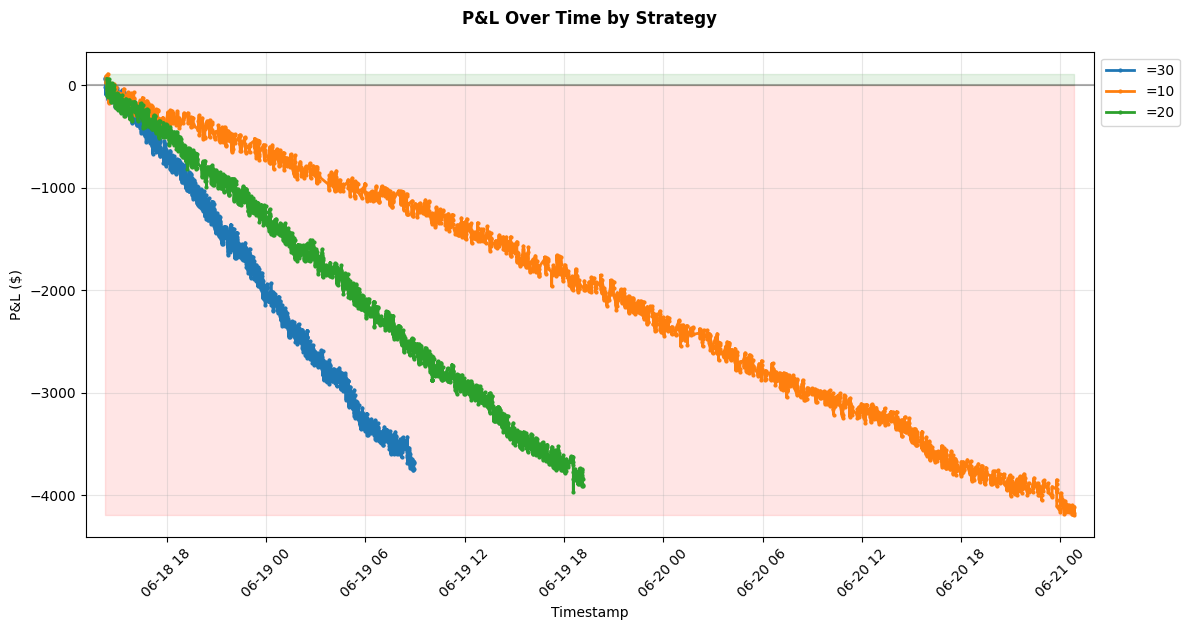

In [ ]:
# import seaborn as sns
# import seaborn as sns
# from tabulate import tabulate

# # Calculate and display metrics for each strategy
# metrics_data = []
# for strategy_name in history['strategy'].unique():
#     strategy_data = history[history['strategy'] == strategy_name].copy()  # Create copy to avoid warning
    
#     # Calculate cumulative P&L by summing cash flows
#     strategy_data.loc[:, 'cum_pl'] = strategy_data['cash_flow'].cumsum()
    
#     strategy_metrics = {
#         'Strategy': strategy_name.split("trade_frequency")[-1].split(",")[0],
#         'Total P&L': f"${strategy_data['cash_flow'].sum():.2f}",
#         'Win Rate': f"{len(strategy_data[strategy_data['cash_flow'] > 0]) / len(strategy_data):.1%}",
#         'Avg Trade': f"${strategy_data['cash_flow'].mean():.2f}", 
#         'Max Drawdown': f"${(strategy_data['cum_pl'] - strategy_data['cum_pl'].expanding().max()).min():.2f}",
#         'Total Trades': len(strategy_data)
#     }
#     metrics_data.append(strategy_metrics)

# # Print metrics table
# print("\nStrategy Performance Metrics:")
# print(tabulate(metrics_data, headers='keys', tablefmt='fancy_grid'))
# print("\n")

# # Plot P&L over time grouped by strategy
# plt.figure(figsize=(12, 6))
# plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# # Get all unique timestamps across all strategies
# all_timestamps = history['timestamp'].unique()
# timestamp_range = [all_timestamps.min(), all_timestamps.max()]

# # Get min/max P&L values across all strategies
# all_pls = []
# for strategy_name in history['strategy'].unique():
#     strategy_data = history[history['strategy'] == strategy_name].copy()
#     strategy_data.loc[:, 'cum_pl'] = strategy_data['cash_flow'].cumsum()
#     all_pls.extend(strategy_data['cum_pl'].values)
    
# y_min = min(min(all_pls), 0)
# y_max = max(max(all_pls), 0)

# # Fill profit/loss zones for full timestamp range
# plt.fill_between(timestamp_range, 0, y_min, alpha=0.1, color='red')
# plt.fill_between(timestamp_range, 0, y_max, alpha=0.1, color='green')

# # Plot P&L lines for each strategy
# for strategy_name in history['strategy'].unique():
#     strategy_data = history[history['strategy'] == strategy_name].copy()
#     strategy_data.loc[:, 'cum_pl'] = strategy_data['cash_flow'].cumsum()
#     plt.plot(strategy_data['timestamp'], 
#              strategy_data['cum_pl'],
#              label=strategy_name.split("trade_frequency")[-1].split(",")[0],
#              linewidth=2,
#              marker='.',  # Add markers to show actual data points
#              markersize=4)

# plt.title('P&L Over Time by Strategy', pad=20, fontsize=12, fontweight='bold')
# plt.xlabel('Timestamp', fontsize=10)
# plt.ylabel('P&L ($)', fontsize=10)
# plt.grid(True, alpha=0.3)
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# plt.tight_layout()
# plt.xticks(rotation=45)
# plt.margins(x=0.02)

# plt.show()